In [1]:
"""
bionsbm

Copyright(C) 2021 fvalle1 & gmalagol10

This program is free software: you can redistribute it and / or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY
without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see < http: // www.gnu.org/licenses/>.
"""

import warnings
warnings.filterwarnings("ignore")
import functools
import os, sys
import logging

from graph_tool.all import load_graph, Graph, minimize_nested_blockmodel_dl

import numpy as np
import pandas as pd
import cloudpickle as pickle

from muon import MuData
from anndata import AnnData
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Any, Dict, List, Optional, Tuple
from scipy import sparse
from numba import njit
# Configure logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

if not logger.handlers:  # prevent adding multiple handlers
    ch = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logger.addHandler(ch)
######################################
import time
from muon import read_h5mu

In [ ]:
mdata=read_h5mu("Datasets/PBMC/CM/PBMC_Peak_mRNA_lncRNA_Mowgli_Def.h5mu")
mdata_red=MuData({"Peak" : mdata["Peak"][:1000, :1000].copy(), "mRNA" : mdata["mRNA"][:1000, :700].copy(), "lncRNA" : mdata["lncRNA"][:1000, :500].copy()})
for mod in mdata_red.mod:
    print(mod)
    print(type(mdata_red[mod].X))
    mdata_red[mod].X=scipy.sparse.csr_matrix(mdata_red[mod].X)
    print(type(mdata_red[mod].X))

del mdata_red["Peak"].uns, mdata_red["mRNA"].uns, mdata_red["lncRNA"].uns, mdata_red["mRNA"].obs, mdata_red["lncRNA"].obs
mdata_red.var=pd.DataFrame(index=mdata_red.var.index)

In [ ]:
mdata_red.write("../Test_data.h5mu", compression="gzip")

# Class

In [2]:
def subsample_mudata(
    mdata: MuData,
    cell_frac: float = 0.5,
    feat_frac: float = None,
    strat_mod: str = "Peak",
    strat_col: str = "CellType",
    random_seed: int = 42
) -> MuData:
    """
    Subsample a MuData object.

    Parameters
    ----------
    mdata : MuData
        The MuData object to subsample.
    cell_frac : float
        Fraction of cells to keep.
    feat_frac : float
        Fraction of features to keep in each modality.
    strat_mod : str
        Name of modality to use for stratified cell sampling.
    strat_col : str
        Column in .obs to use for stratification.
    random_seed : int
        Random seed for reproducibility.

    Returns
    -------
    MuData
        Subsampled MuData object.
    """
    if feat_frac is None:
        feat_frac = cell_frac
    np.random.seed(random_seed)
    
    # --- Subsample cells stratified ---
    celltypes = mdata[strat_mod].obs[strat_col]
    n_cells = int(np.ceil(cell_frac * mdata.n_obs))
    
    # compute group sizes proportionally
    counts = (celltypes.value_counts(normalize=True) * n_cells).round().astype(int)
    
    sampled_idx = []
    for ct, n in counts.items():
        sampled_idx.extend(celltypes[celltypes == ct].sample(n, random_state=random_seed).index)
    
    mdata_cells = mdata[sampled_idx, :]
    
    # --- Subsample features per modality ---
    mod_subsampled = {}
    for mod in mdata_cells.mod.keys():
        adata = mdata_cells[mod]
        n_feats = int(np.ceil(feat_frac * adata.n_vars))
        n_feats = min(n_feats, adata.n_vars)
        feat_idx = np.random.choice(adata.n_vars, size=n_feats, replace=False)
        mod_subsampled[mod] = adata[:, feat_idx].copy()
    
    # Return new MuData object
    return MuData(mod_subsampled)

In [16]:
class bionsbm():
	"""
	Class to run bionsbm
	"""
	def __init__(self, obj, label: Optional[str] = None, max_depth: int = 6, modality: str = "Mod1", saving_path: str = "results/myself"):
		"""
		Initialize a bionsbm self.

		This constructor sets up the graph representation of the input data
		(`AnnData` or `MuData`) and optionally assigns node types based on a label.

		Parameters
		----------
		obj : muon.MuData or anndata.AnnData
			Input data object. If `MuData`, all modalities are extracted; if `AnnData`,
			only the provided `modality` is used.
		label : str, optional
			Column in `.obs` used to assign document labels and node types.
			If provided, the graph is annotated accordingly.
		max_depth : int, default=6
			Maximum number of levels to save or annotate in the hierarchical self.
		modality : str, default="Mod1"
			Name of the modality to use when the input is `AnnData`.
		saving_path : str, default="results/myself"
			Base path for saving self outputs (graph, state, results).

		Notes
		-----
		- For `MuData`, multiple modalities are combined into a multi-branch graph.
		- If `label` is provided, a mapping is created to encode document/node types.
		- `self.g` (graph) and related attributes (`documents`, `words`, `keywords`)
		  are initialized by calling `self.make_graph(...)`.
		"""
		super().__init__()
		self.keywords: List = []
		self.nbranches: int = 1
		self.modalities: List[str] = []
		self.max_depth: int = max_depth
		self.obj: Any = obj
		self.saving_path: str = saving_path

		if isinstance(obj, MuData):
			self.modalities=list(obj.mod.keys())   
			dfs=[obj[key].to_df().T for key in self.modalities]
			self.make_graph(dfs[0], dfs[1:])

		elif isinstance(obj, AnnData):
			self.modalities=[modality]
			self.make_graph(obj.to_df().T, [])

		if label:
			g_raw=self.g.copy()
			logger.info("Label found")
			metadata=obj[self.modalities[0]].obs
			mymap = dict([(y,str(x)) for x,y in enumerate(sorted(set(obj[self.modalities[0]].obs[label])))])
			inv_map = {v: k for k, v in mymap.items()}

			docs_type=[int(mymap[metadata.loc[doc][label]]) for doc in self.documents]
			types={}
			types["Docs"]=docs_type
			for i, key in enumerate(self.modalities):
				types[key]=[int(i+np.max(docs_type)+1) for a in range(0, obj[key].shape[0])]
			node_type = g_raw.new_vertex_property('int', functools.reduce(lambda a, b : a+b, list(types.values())))
			self.g = g_raw.copy()
		else:
			node_type=None
		self.node_type=node_type 


	def make_graph(self, df_base: pd.DataFrame, df_keyword_list: List[pd.DataFrame]) -> None:

		"""
		Construct a graph-tool graph from a single feature matrix.

		This method builds a bipartite or multi-branch graph from the given
		DataFrame, where columns represent documents/samples and rows represent
		features (e.g., words, genes, or keywords). Vertices are created for
		both documents and features, and weighted edges connect documents to
		their features.

		Parameters
		----------
		df : pandas.DataFrame
			Feature matrix with rows as features (words, genes, or keywords)
			and columns as documents/samples. The values must be numeric and
			represent counts or weights of feature occurrences.
		get_kind : callable
			Function that takes a feature name (row index from ``df``) and
			returns an integer specifying the vertex kind:
			- 0 → document nodes
			- 1 → main feature nodes
			- 2, 3, ... → keyword/meta-feature branch nodes

		Notes
		-----
		- The constructed graph is undirected.
		- Vertices are annotated with two properties:
		  * ``name`` (string): document or feature name.
		  * ``kind`` (int): node type (document, word, or keyword branch).
		- Edges are annotated with ``count`` (int), representing the weight.
		- Edges with zero weight are removed after construction.
		- The graph is stored in ``self.g``

		Raises
		------
		ValueError
			If the resulting graph has no edges (i.e., ``df`` is empty or contains only zeros).	
		"""
		
		if os.path.isfile(f"{self.saving_path}_graph.xml.gz") == True: 
			logger.info("Loading graph from %d", f"{self.saving_path}_graph.xml.gz")
			self.load_graph(filename=f"{self.saving_path}_graph.xml.gz")
		else:  
			logger.info("Creating graph from scratch")

			df = df_base.copy(deep =True)
			for ikey,df_keyword in enumerate(df_keyword_list):
				df_keyword = df_keyword.reindex(columns=df.columns)
				df_keyword.index = ["".join(["#" for _ in range(ikey+1)])+str(keyword) for keyword in df_keyword.index]
				df_keyword["kind"] = ikey+2
				df = pd.concat((df,df_keyword), axis=0)
	
			def get_kind(word):
				return 1 if word in df.index else df.at[word,"kind"]
	
			self.nbranches = len(df_keyword_list)
			del df_keyword_list, df_base

			df=df.drop("kind", axis=1, errors='ignore')

			logger.info("Building graph with %d docs and %d words", df.shape[1], df.shape[0])
			
			self.g = Graph(directed=False)
	
			n_docs, n_words = df.shape[1], df.shape[0]
		
			# Add all vertices first
			self.g.add_vertex(n_docs + n_words)
		
			# Create vertex properties
			name = self.g.new_vp("string")
			kind = self.g.new_vp("int")
			self.g.vp["name"] = name
			self.g.vp["kind"] = kind
		
			# Assign doc vertices (loop for names, array for kind)
			for i, doc in enumerate(df.columns):
				name[self.g.vertex(i)] = doc
			kind.get_array()[:n_docs] = 0
		
			# Assign word vertices (loop for names, array for kind)
			for j, word in enumerate(df.index):
				name[self.g.vertex(n_docs + j)] = word
			kind.get_array()[n_docs:] = np.array([get_kind(w) for w in df.index], dtype=int)
		
			# Edge weights
			weight = self.g.new_ep("int")
			self.g.ep["count"] = weight
		
			# Build sparse edges
			rows, cols = df.values.nonzero()
			vals = df.values[rows, cols].astype(int)
			edges = [(c, n_docs + r, v) for r, c, v in zip(rows, cols, vals)]
			if len(edges)==0: raise ValueError("Empty graph")
		
			self.g.add_edge_list(edges, eprops=[weight])
		
			# Remove edges with 0 weight
			filter_edges = self.g.new_edge_property("bool")
			filter_edges.a = weight.a > 0
			self.g.set_edge_filter(filter_edges)
			self.g.purge_edges()
			self.g.clear_filters()
		
			self.documents = df.columns
			self.words = df.index[self.g.vp['kind'].a[n_docs:] == 1]
			for ik in range(2, 2 + self.nbranches):
				self.keywords.append(df.index[self.g.vp['kind'].a[n_docs:] == ik])
	
			folder = os.path.dirname(self.saving_path)
			Path(folder).mkdir(parents=True, exist_ok=True)
			self.save_graph(filename=f"{self.saving_path}_graph.xml.gz")


	def fit(self, n_init=1, verbose=True, deg_corr=True, overlap=False, parallel=False, B_min=0, B_max=None, clabel=None, *args, **kwargs) -> None:
		"""
		Fit a nested stochastic block self to the graph using `minimize_nested_blockmodel_dl`.
	
		This method performs multiple initializations and keeps the best self 
		based on the minimum description length (entropy). It supports degree-corrected 
		and overlapping block selfs, and can perform parallel moves for efficiency.
	
		Parameters
		----------
		n_init : int, default=1
			Number of random initializations. The self with the lowest entropy is retained.
		verbose : bool, default=True
			If True, print progress messages.
		deg_corr : bool, default=True
			If True, use a degree-corrected block self.
		overlap : bool, default=False
			If True, use an overlapping block self.
		parallel : bool, default=False
			If True, perform parallel moves during optimization.
		B_min : int, default=0
			Minimum number of blocks to consider.
		B_max : int, optional
			Maximum number of blocks to consider. Defaults to the number of vertices.
		clabel : str or property map, optional
			Vertex property to use as initial block assignment. If None, the 'kind' 
			vertex property is used.
		*args : positional arguments
			Additional positional arguments passed to `minimize_nested_blockmodel_dl`.
		**kwargs : keyword arguments
			Additional keyword arguments passed to `minimize_nested_blockmodel_dl`. 
		"""
		if clabel == None:
			clabel = self.g.vp['kind']
			state_args = {'clabel': clabel, 'pclabel': clabel}
		else:
			logger.info("Clabel is %s, assigning partitions to vertices", clabel)
			state_args = {'clabel': clabel, 'pclabel': clabel}
	
		state_args["eweight"] = self.g.ep.count
		min_entropy = np.inf
		best_state = None
		state_args["deg_corr"] = deg_corr
		state_args["overlap"] = overlap

		if B_max is None:
			B_max = self.g.num_vertices()
			
		multilevel_mcmc_args={"B_min": B_min, "B_max": B_max, "verbose": verbose,"parallel" : parallel}

		logger.debug("multilevel_mcmc_args: %s", multilevel_mcmc_args)
		logger.debug("state_args: %s", state_args)

		for i in range(n_init):
			logger.info("Fit number: %d", i)
			state = minimize_nested_blockmodel_dl(self.g, state_args=state_args, multilevel_mcmc_args=multilevel_mcmc_args, *args, **kwargs)
			
			entropy = state.entropy()
			if entropy < min_entropy:
				min_entropy = entropy
				self.state = state
				
		self.mdl = min_entropy

		L = len(self.state.levels)
		self.L = L

		self.groups = {}
		logger.info("Saving data in %s", self.saving_path)
		self.save_data(path_to_save=self.saving_path)

		logger.info("Annotate object")
		self.annotate_obj()


	# Helper functions
	def save_graph(self, filename: str = "graph.xml.gz") -> None:
		"""
		Save the graph

		:param filename: name of the graph stored
		"""
		logger.info("Saving graph to %s", filename)
		self.g.save(filename)
	
	
	def load_graph(self, filename: str = "graph.xml.gz") -> None:
		"""
		Load a saved graph from disk and rebuild documents, words, and keywords.

		Parameters
		----------
		filename : str, optional
			Path to the saved graph file (default: "graph.xml.gz").
		"""
		logger.info("Loading graph from %s", filename)

		self.g = load_graph(filename)
		self.documents = [self.g.vp['name'][v] for v in self.g.vertices() if self.g.vp['kind'][v] == 0]
		self.words = [self.g.vp['name'][v] for v in self.g.vertices() if self.g.vp['kind'][v] == 1]
		metadata_indexes = np.unique(self.g.vp["kind"].a)
		metadata_indexes = metadata_indexes[metadata_indexes > 1] #no doc or words
		self.nbranches = len(metadata_indexes)
		for i_keyword in metadata_indexes:
			self.keywords.append([self.g.vp['name'][v] for v in self.g.vertices() if self.g.vp['kind'][v] == i_keyword])

	
	def _get_edge_cache(self):
		"""
		Cache edge sources, targets, weights, and kinds once per graph.
		"""
		if hasattr(self, "_edge_cache"):
			return self._edge_cache
	
		edge_array = self.g.get_edges()  # shape (m, 2)
		sources = edge_array[:, 0].astype(np.int64)
		targets = edge_array[:, 1].astype(np.int64)
	
		weights = self.g.ep["count"].a.astype(np.float64)
		kinds = self.g.vp["kind"].a[targets].astype(np.int64)
	
		self._edge_cache = {"sources": sources, "targets": targets, "weights": weights, "kinds": kinds}
		return self._edge_cache
	
	
	def _get_state_l_edges_array(self, state_l):
		"""
		Cache block assignments (z1, z2) once per hierarchy level.
		"""
		if hasattr(state_l, "_edges_array_cache"):
			return state_l._edges_array_cache
	
		edges = list(self.g.edges())
		state_l_edges = state_l.get_edge_blocks()
	
		arr = np.empty((len(edges), 2), dtype=np.int64)
		for i, e in enumerate(edges):
			arr[i, 0] = state_l_edges[e][0]
			arr[i, 1] = state_l_edges[e][1]
	
		state_l._edges_array_cache = arr
		return arr
	
	
	def get_groups(self, l=0):
		"""
		Fully optimized get_groups with caching of edges and block assignments.
		No per-edge Python loops in the hot path.
		"""
		if l in self.groups:
			return self.groups[l]
	
		# --- Setup ---
		state_l = self.state.project_level(l).copy(overlap=True)
		B = state_l.get_B()
		D, W, K = self.get_shape()
		nbranches = self.nbranches
		K_arr = np.array(K, dtype=np.int64)
	
		# --- Precompute branch offsets ---
		if nbranches > 0 and K_arr.size > 0:
			prefix_K = np.empty(nbranches, dtype=np.int64)
			prefix_K[0] = 0
			for ii in range(1, nbranches):
				prefix_K[ii] = prefix_K[ii-1] + K_arr[ii-1]
			offsets = (D + W) + prefix_K
		else:
			offsets = np.empty(0, dtype=np.int64)
	
		# --- Get cached edge arrays ---
		edge_cache = _get_edge_cache(self)
		sources = edge_cache["sources"]
		targets = edge_cache["targets"]
		weights = edge_cache["weights"]
		kinds = edge_cache["kinds"]
	
		# --- Get cached block assignments ---
		z_pairs = _get_state_l_edges_array(self, state_l)
		z1_arr = z_pairs[:, 0]
		z2_arr = z_pairs[:, 1]
	
		# --- Allocate accumulators ---
		n_wb = np.zeros((W, B), dtype=np.float64)
		n_db = np.zeros((D, B), dtype=np.float64)
		n_dbw = np.zeros((D, B), dtype=np.float64)
		n_w_key_b3 = np.zeros((nbranches, np.max(K_arr) if nbranches > 0 else 0, B), dtype=np.float64)
		n_dbw_key3 = np.zeros((nbranches, D, B), dtype=np.float64)
	
		# --- Process edges ---
		process_edges_numba_stack(sources, targets, z1_arr, z2_arr, kinds, weights, D, W, K_arr, offsets, nbranches, n_db, n_wb, n_dbw, n_w_key_b3, n_dbw_key3)
	
		# --- Trim and normalize (unchanged) ---
		ind_d = np.where(np.sum(n_db, axis=0) > 0)[0]
		n_db = n_db[:, ind_d]
		Bd = len(ind_d)
	
		ind_w = np.where(np.sum(n_wb, axis=0) > 0)[0]
		n_wb = n_wb[:, ind_w]
		Bw = len(ind_w)
	
		ind_w2 = np.where(np.sum(n_dbw, axis=0) > 0)[0]
		n_dbw = n_dbw[:, ind_w2]
	
		n_w_key_b_list, n_dbw_key_list, Bk = [], [], []
		for ik in range(nbranches):
			Kk = int(K_arr[ik]) if K_arr.size > 0 else 0
			if Kk > 0:
				col_sums = np.sum(n_w_key_b3[ik, :Kk, :], axis=0)
				ind_wk = np.where(col_sums > 0)[0]
				if ind_wk.size > 0:
					n_w_key_b_list.append(n_w_key_b3[ik, :Kk, :][:, ind_wk].copy())
				else:
					n_w_key_b_list.append(np.zeros((Kk, 0), dtype=np.float64))
				Bk.append(len(ind_wk))
			else:
				n_w_key_b_list.append(np.zeros((0, 0), dtype=np.float64))
				Bk.append(0)
	
			col_sums_dbw = np.sum(n_dbw_key3[ik], axis=0)
			ind_w2k = np.where(col_sums_dbw > 0)[0]
			if ind_w2k.size > 0:
				n_dbw_key_list.append(n_dbw_key3[ik][:, ind_w2k].copy())
			else:
				n_dbw_key_list.append(np.zeros((D, 0), dtype=np.float64))
	
		# --- Distributions ---
		denom = np.sum(n_wb, axis=1, keepdims=True)
		p_tw_w = (n_wb / denom).T
	
		p_tk_w_key = []
		for ik in range(nbranches):
			arr = n_w_key_b_list[ik]
			denom = np.sum(arr, axis=1, keepdims=True)
			p_tk_w_key.append((arr / denom).T)
	
		denom = np.sum(n_wb, axis=0, keepdims=True)
		p_w_tw = n_wb / denom
	
		p_w_key_tk = []
		for ik in range(nbranches):
			arr = n_w_key_b_list[ik]
			denom = np.sum(arr, axis=0, keepdims=True)
			p_w_key_tk.append(arr / denom)
	
		denom = np.sum(n_dbw, axis=1, keepdims=True)
		p_tw_d = (n_dbw / denom).T
	
		p_tk_d = []
		for ik in range(nbranches):
			arr = n_dbw_key_list[ik]
			denom = np.sum(arr, axis=1, keepdims=True)
			p_tk_d.append((arr / denom).T)
	
		denom = np.sum(n_db, axis=1, keepdims=True)
		p_td_d = (n_db / denom).T
	
		result = {'Bd': Bd, 'Bw': Bw, 'Bk': Bk,
					'p_tw_w': p_tw_w, 'p_tk_w_key': p_tk_w_key, 'p_td_d': p_td_d,
					'p_w_tw': p_w_tw, 'p_w_key_tk': p_w_key_tk, 'p_tw_d': p_tw_d, 'p_tk_d': p_tk_d}
	
		self.groups[l] = result
		return result



	def save_single_level(self, l: int, path_to_save: str) -> None:
		"""
		Save per-level probability matrices (topics, clusters, documents) for the given level.

		Parameters
		----------
		l : int
			The level index to save. Must be within the range of available self levels.
		savingpath_to_save_path : str
			Base path (folder + prefix) where files will be written.
			Example: "results/myself" → files like:
				- results/myself_level_0_mainfeature_topics.tsv.gz
				- results/myself_level_0_clusters.tsv.gz
				- results/myself_level_0_mainfeature_topics_documents.tsv.gz
				- results/myself_level_0_metafeature_topics.tsv.gz
				- results/myself_level_0_metafeature_topics_documents.tsv.gz

		Notes
		-----
		- Files are written as tab-separated values (`.tsv.gz`) with gzip compression.
		- Raises RuntimeError if any file cannot be written.
		"""

		# --- Validate inputs ---
		if not isinstance(l, int) or l < 0 or l >= len(self.state.levels) or l >= len(self.state.levels):
			raise ValueError(f"Invalid level index {l}. Must be between 0 and {len(self.state.levels) - 1}.")
		if not isinstance(path_to_save, str) or not path_to_save.strip():
			raise ValueError("`path_to_save` must be a non-empty string path prefix.")

		main_feature = self.modalities[0]

		try:
			data = self.get_groups(l)
		except Exception as e:
			raise RuntimeError(f"Failed to get group data for level {l}: {e}") from e

		# Helper to safely save a DataFrame
		def _safe_save(df, filepath):
			try:
				Path(filepath).parent.mkdir(parents=True, exist_ok=True)
				df.to_csv(filepath, compression="gzip", sep="\t")
			except Exception as e:
				raise RuntimeError(f"Failed to save {filepath}: {e}") from e

		# --- P(document | cluster) ---
		clusters = pd.DataFrame(data=data["p_td_d"], columns=self.documents)
		_safe_save(clusters, f"{path_to_save}_level_{l}_clusters.tsv.gz")


		# --- P(main_feature | main_topic) ---
		p_w_tw = pd.DataFrame(data=data["p_w_tw"], index=self.words,
			columns=[f"{main_feature}_topic_{i}" for i in range(data["p_w_tw"].shape[1])])
		_safe_save(p_w_tw, f"{path_to_save}_level_{l}_{main_feature}_topics.tsv.gz")

		# --- P(main_topic | documents) ---
		p_tw_d = pd.DataFrame(data=data["p_tw_d"].T,index=self.documents,
			columns=[f"{main_feature}_topic_{i}" for i in range(data["p_w_tw"].shape[1])])
		_safe_save(p_tw_d, f"{path_to_save}_level_{l}_{main_feature}_topics_documents.tsv.gz")

		# --- P(meta_feature | meta_topic_feature), if any ---
		if len(self.modalities) > 1:
			for k, meta_features in enumerate(self.modalities[1:]):
				p_w_tw = pd.DataFrame(data=data["p_w_key_tk"][k], index=self.keywords[k],
					columns=[f"{meta_features}_topic_{i}" for i in range(data["p_w_key_tk"][k].shape[1])])
				_safe_save(p_w_tw, f"{path_to_save}_level_{l}_{meta_features}_topics.tsv.gz")


			# --- P(meta_topic | document) ---
			for k, meta_features in enumerate(self.modalities[1:]):
				p_tw_d = pd.DataFrame(data=data["p_tk_d"][k].T, index=self.documents,
					columns=[f"{meta_features}_topics_{i}" for i in range(data["p_w_key_tk"][k].shape[1])])
				_safe_save(p_tw_d, f"{path_to_save}_level_{l}_{meta_features}_topics_documents.tsv.gz")



	def save_data(self, path_to_save: str = "results/myself") -> None:
		"""
		Save the global graph, self, state, and level-specific data for the current nSBM self.

		Parameters
		----------
		savinpath_to_saveg_path : str, optional
			Base path (folder + prefix) where all outputs will be saved.
			Example: "results/myself" will produce:
				- results/myself_graph.xml.gz
				- results/myself_self.pkl	
				- results/myself_entropy.txt
				- results/myself_state.pkl
				- results/myself_level_X_*.tsv.gz  (per level, up to 6 levels)

		Notes
		-----
		- The parent folder is created automatically if it does not exist.
		- Level saving is parallelized with threads for efficiency in I/O.
		- By default, at most self.max_depth levels are saved, or fewer if the self has <self.max_depth levels.
		"""
		logger.info("Saving self data to %s", path_to_save)

		L = min(len(self.state.levels), self.max_depth)
		self.L = L
		if L == 0:
			logger.warning("Nothing to save (no levels found)")
			return
		
		folder = os.path.dirname(path_to_save)
		Path(folder).mkdir(parents=True, exist_ok=True)

		try:
			self.save_graph(filename=f"{path_to_save}_graph.xml.gz")
			self.dump_self(filename=f"{path_to_save}_self.pkl")

			with open(f"{path_to_save}_entropy.txt", "w") as f:
				f.write(str(self.state.entropy()))

			with open(f"{path_to_save}_state.pkl", "wb") as f:
				pickle.dump(self.state, f)

		except Exception as e:
			logger.error("Failed to save global files: %s", e)
			raise RuntimeError(f"Failed to save global files for self '{path_to_save}': {e}") from e


		errors = []
		with ThreadPoolExecutor() as executor:
			futures = {executor.submit(self.save_single_level, l, path_to_save): l for l in range(L)}
			for future in as_completed(futures):
				l = futures[future]
				try:
					future.result()
				except Exception as e:
					errors.append((l, str(e)))

		if errors:
			msg = "; ".join([f"Level {l}: {err}" for l, err in errors])
			logger.error("Errors occurred while saving levels: %s", msg)
			raise RuntimeError(f"Errors occurred while saving levels: {msg}")


	def annotate_obj(self) -> None:
		L = min(len(self.state.levels), self.max_depth)
		for l in range(0,L):
			main_feature = self.modalities[0]
			data = self.get_groups(l)
			self.obj.obs[f"Level_{l}_cluster"]=np.argmax(pd.DataFrame(data=data["p_td_d"], columns=self.documents)[self.obj.obs.index], axis=0).astype(str)
			
	
			if isinstance(self.obj, MuData):
				order_var=self.obj[main_feature].var.index
				p_w_tw = pd.DataFrame(data=data["p_w_tw"], index=self.words,
								columns=[f"{main_feature}_topic_{i}" for i in range(data["p_w_tw"].shape[1])]).loc[order_var]
				self.obj[main_feature].var[f"Level_{l}_{main_feature}_topic"]=np.argmax(p_w_tw, axis=1).astype(str)

			elif isinstance(self.obj, AnnData):
				order_var=self.obj.var.index			 
				p_w_tw = pd.DataFrame(data=data["p_w_tw"], index=self.words,
								columns=[f"{main_feature}_topic_{i}" for i in range(data["p_w_tw"].shape[1])]).loc[order_var]
				self.obj.var[f"Level_{l}_{main_feature}_topic"]=np.argmax(p_w_tw, axis=1).astype(str)

			
			p_tw_d = pd.DataFrame(data=data["p_tw_d"].T,index=self.documents,
					columns=[f"{main_feature}_topic_{i}" for i in range(data["p_w_tw"].shape[1])]).loc[self.obj.obs.index]
			p_tw_d=p_tw_d-p_tw_d.mean(axis=0)
			self.obj.obs[f"Level_{l}_{main_feature}"]=np.argmax(p_tw_d, axis=1).astype(str)
		
			if len(self.modalities) > 1:
				for k, meta_feature in enumerate(self.modalities[1:]):
					p_w_tw = pd.DataFrame(data=data["p_w_key_tk"][k], index=self.keywords[k],
						columns=[f"{meta_feature}_topic_{i}" for i in range(data["p_w_key_tk"][k].shape[1])])
					self.obj[meta_feature].var[f"Level_{l}_{meta_feature}_topic"]=np.argmax(p_w_tw, axis=1).astype(str)
			
				# --- P(meta_topic | document) ---
				for k, meta_feature in enumerate(self.modalities[1:]):
					p_tw_d = pd.DataFrame(data=data["p_tk_d"][k].T, index=self.documents,
						columns=[f"{meta_feature}_topics_{i}" for i in range(data["p_w_key_tk"][k].shape[1])])
					p_tw_d=p_tw_d-p_tw_d.mean(axis=0)
					self.obj.obs[f"Level_{l}_{meta_feature}"]=np.argmax(p_tw_d, axis=1).astype(str)

	def dump_model(self, filename="bionsbm.pkl"):
		"""
		Dump self using pickle

		"""
		logger.info("Dumping self to %s", filename)

		with open(filename, 'wb') as f:
			pickle.dump(self, f)

	def load_model(self, filename="bionsbm.pkl"):
		logger.info("Loading self from %s", filename)

		with open(filename, "rb") as f:
			self = pickle.load(f)
		return self

	def get_V(self):
		'''
		return number of word-nodes == types
		'''
		return int(np.sum(self.g.vp['kind'].a == 1))  # no. of types

	def get_D(self):
		'''
		return number of doc-nodes == number of documents
		'''
		return int(np.sum(self.g.vp['kind'].a == 0))  # no. of types

	def get_N(self):
		'''
		return number of edges == tokens
		'''
		return int(self.g.num_edges())  # no. of types


	def get_mdl(self):
		"""
		Get minimum description length

		Proxy to self.state.entropy()
		"""
		return self.mdl
			
	def get_shape(self):
		"""
		:return: list of tuples (number of documents, number of words, (number of keywords,...))
		"""
		D = int(np.sum(self.g.vp['kind'].a == 0)) #documents
		W = int(np.sum(self.g.vp['kind'].a == 1)) #words
		K = [int(np.sum(self.g.vp['kind'].a == (k+2))) for k in range(self.nbranches)] #keywords
		return D, W, K

##### Drawing
	def draw(self, *args, **kwargs) -> None:
		"""
		Draw the network

		:param \*args: positional arguments to pass to self.state.draw
		:param \*\*kwargs: keyword argument to pass to self.state.draw
		"""
		colmap = self.g.vertex_properties["color"] = self.g.new_vertex_property(
			"vector<double>")
		#https://medialab.github.io/iwanthue/
		colors = [  [174,80,209],
					[108,192,70],
					[207, 170, 60],
					[131,120,197],
					[126,138,65],
					[201,90,138],
					[87,172,125],
					[213,73,57],
					[85,175,209],
					[193,120,81]]
		for v in self.g.vertices():
			k = self.g.vertex_properties['kind'][v]
			if k < 10:
				color = np.array(colors[k])/255.
			else:
				color = np.array([187, 129, 164])/255.
			colmap[v] = color
		self.state.draw(
			subsample_edges = 5000, 
			edge_pen_width = self.g.ep["count"],
			vertex_color=colmap,
			vertex_fill_color=colmap, *args, **kwargs)

In [17]:
mdata = read_h5mu("../Test_data.h5mu")

In [18]:
model = bionsbm(obj=mdata, saving_path="results/mybionsbm")

--- Logging error ---
Traceback (most recent call last):
  File "/home/gabriele/miniconda3/envs/gt/lib/python3.13/logging/__init__.py", line 1151, in emit
    msg = self.format(record)
  File "/home/gabriele/miniconda3/envs/gt/lib/python3.13/logging/__init__.py", line 999, in format
    return fmt.format(record)
           ~~~~~~~~~~^^^^^^^^
  File "/home/gabriele/miniconda3/envs/gt/lib/python3.13/logging/__init__.py", line 712, in format
    record.message = record.getMessage()
                     ~~~~~~~~~~~~~~~~~^^
  File "/home/gabriele/miniconda3/envs/gt/lib/python3.13/logging/__init__.py", line 400, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: %d format: a real number is required, not str
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/gabriele/miniconda3/envs/gt/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()


In [19]:
model.fit(n_init=1, verbose=False)

2025-09-15 18:59:17,896 - INFO - Fit number: 0
2025-09-15 18:59:29,671 - INFO - Saving data in results/mybionsbm
2025-09-15 18:59:29,672 - INFO - Saving self data to results/mybionsbm
2025-09-15 18:59:29,672 - INFO - Saving graph to results/mybionsbm_graph.xml.gz
2025-09-15 18:59:29,726 - INFO - Dumping self to results/mybionsbm_self.pkl
2025-09-15 18:59:29,976 - ERROR - Errors occurred while saving levels: Level 1: Failed to get group data for level 1: name '_get_edge_cache' is not defined; Level 2: Failed to get group data for level 2: name '_get_edge_cache' is not defined; Level 4: Failed to get group data for level 4: name '_get_edge_cache' is not defined; Level 3: Failed to get group data for level 3: name '_get_edge_cache' is not defined; Level 5: Failed to get group data for level 5: name '_get_edge_cache' is not defined; Level 0: Failed to get group data for level 0: name '_get_edge_cache' is not defined


RuntimeError: Errors occurred while saving levels: Level 1: Failed to get group data for level 1: name '_get_edge_cache' is not defined; Level 2: Failed to get group data for level 2: name '_get_edge_cache' is not defined; Level 4: Failed to get group data for level 4: name '_get_edge_cache' is not defined; Level 3: Failed to get group data for level 3: name '_get_edge_cache' is not defined; Level 5: Failed to get group data for level 5: name '_get_edge_cache' is not defined; Level 0: Failed to get group data for level 0: name '_get_edge_cache' is not defined

# New make_graph

In [4]:
mdata=read_h5mu("../Test_data.h5mu")
mdata

MuData object with n_obs × n_vars = 1000 × 2200
  var:	'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
  3 modalities
    Peak:	1000 x 1000
      obs:	'RNA_celltype', 'Raw_CellType', 'CellType', 'nucleosome_signal', 'tss_enrichment_score', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'tss', 'passes_filter'
      var:	'chr', 'start', 'stop', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    mRNA:	1000 x 700
      var:	'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    lncRNA:	1000 x 500
      var:	'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'

In [29]:
def make_graph_multiple_df(self., df: pd.DataFrame, df_keyword_list: list, fast=True)->None:
    """
    Create a graph from two dataframes one with words, others with keywords or other layers of information

    :param df: DataFrame with words on index and texts on columns
    :param df_keyword_list: list of DataFrames with keywords on index and texts on columns
    """
    df_all = df.copy(deep =True)
    for ikey,df_keyword in enumerate(df_keyword_list):
        df_keyword = df_keyword.reindex(columns=df.columns)
        df_keyword.index = ["".join(["#" for _ in range(ikey+1)])+str(keyword) for keyword in df_keyword.index]
        df_keyword["kind"] = ikey+2
        df_all = pd.concat((df_all,df_keyword), axis=0)

    def get_kind(word):
        return 1 if word in df.index else df_all.at[word,"kind"]

    self.nbranches = len(df_keyword_list)

    if fast:
        make_graph_fast(self., df_all.drop("kind", axis=1, errors='ignore'), get_kind)
    else:
        make_graph(self., df_all.drop("kind", axis=1, errors='ignore'), get_kind)
    
def make_graph(self., df: pd.DataFrame, get_kind) -> None:
    """
    Create a graph from a pandas DataFrame

    :param df: DataFrame with words on index and texts on columns. Actually this is a BoW.
    :param get_kind: function that returns 1 or 2 given an element of df.index. [1 for words 2 for keywords]
    """
    self.g = Graph(directed=False)
    name = self.g.vp["name"] = self.g.new_vp("string")
    kind = self.g.vp["kind"] = self.g.new_vp("int")
    weight = self.g.ep["count"] = self.g.new_ep("int")

    for doc in df.columns:
        d = self.g.add_vertex()
        name[d] = doc
        kind[d] = 0

    for word in df.index:
        w = self.g.add_vertex()
        name[w] = word
        kind[w] = get_kind(word)

    D = df.shape[1]

    for i_doc, doc in enumerate(df.columns):
        text = df[doc]
        self.g.add_edge_list([(i_doc, D + x[0][0], x[1]) for x in zip(enumerate(df.index), text)], eprops=[weight])

    filter_edges = self.g.new_edge_property("bool")
    for e in self.g.edges():
        filter_edges[e] = weight[e] > 0

    self.g.set_edge_filter(filter_edges)
    self.g.purge_edges()
    self.g.clear_filters()

    self.documents = df.columns
    self.words = df.index[self.g.vp['kind'].a[D:] == 1]
    for ik in range(2, 2 + self.nbranches):  # 2 is doc and words
        self.keywords.append(df.index[self.g.vp['kind'].a[D:] == ik])

def make_graph_fast(self., df: pd.DataFrame, get_kind):
    self.g = Graph(directed=False)

    n_docs, n_words = df.shape[1], df.shape[0]

    # Add all vertices first
    self.g.add_vertex(n_docs + n_words)

    # Create vertex properties
    name = self.g.new_vp("string")
    kind = self.g.new_vp("int")
    self.g.vp["name"] = name
    self.g.vp["kind"] = kind

    # Assign doc vertices (loop for names, array for kind)
    for i, doc in enumerate(df.columns):
        name[self.g.vertex(i)] = doc
    kind.get_array()[:n_docs] = 0

    # Assign word vertices (loop for names, array for kind)
    for j, word in enumerate(df.index):
        name[self.g.vertex(n_docs + j)] = word
    kind.get_array()[n_docs:] = np.array([get_kind(w) for w in df.index], dtype=int)

    # Edge weights
    weight = self.g.new_ep("int")
    self.g.ep["count"] = weight

    # Build sparse edges
    rows, cols = df.values.nonzero()
    vals = df.values[rows, cols].astype(int)
    edges = [(c, n_docs + r, v) for r, c, v in zip(rows, cols, vals)]
    if len(edges)==0: raise ValueError("Empty graph")

    self.g.add_edge_list(edges, eprops=[weight])

    # Remove edges with 0 weight
    filter_edges = self.g.new_edge_property("bool")
    filter_edges.a = weight.a > 0
    self.g.set_edge_filter(filter_edges)
    self.g.purge_edges()
    self.g.clear_filters()

    self.documents = df.columns
    self.words = df.index[self.g.vp['kind'].a[n_docs:] == 1]
    for ik in range(2, 2 + self.nbranches):
        self.keywords.append(df.index[self.g.vp['kind'].a[n_docs:] == ik])

In [30]:
# ----------------------------
# Compare self.s
# ----------------------------
def compare_self.s(m1, m2):
    g1, g2 = m1.g, m2.g

    assert g1.num_vertices() == g2.num_vertices(), "Different number of vertices"
    assert g1.num_edges() == g2.num_edges(), "Different number of edges"

    for prop in ["name", "kind"]:
        p1, p2 = g1.vp[prop], g2.vp[prop]
        vals1 = [p1[v] for v in g1.vertices()]
        vals2 = [p2[v] for v in g2.vertices()]
        assert vals1 == vals2, f"Vertex property {prop} differs"

    w1, w2 = g1.ep["count"], g2.ep["count"]
    edges1 = sorted([(int(e.source()), int(e.target()), int(w1[e])) for e in g1.edges()])
    edges2 = sorted([(int(e.source()), int(e.target()), int(w2[e])) for e in g2.edges()])
    assert edges1 == edges2, "Edges or weights differ"

    assert list(m1.documents) == list(m2.documents), "Documents differ"
    assert np.array_equal(m1.words, m2.words), "Words differ"
    assert len(m1.keywords) == len(m2.keywords), "Different number of keyword groups"
    for i, (kw1, kw2) in enumerate(zip(m1.keywords, m2.keywords)):
        assert np.array_equal(kw1, kw2), f"Keywords differ at branch {i}"

    return True


# ----------------------------
# Benchmark with correctness check
# ----------------------------
def benchmark_and_check(mdata):
    # Old
    modalities=list(mdata.mod.keys())   
    dfs=[mdata[key].to_df().T for key in modalities]
    
    t0 = time.time()
    self.1 = bionsbm(obj=mdata)
    make_graph_multiple_df(self.1, dfs[0], dfs[1:], fast=False)
    t1 = time.time()
    old_time = t1 - t0

    # New
    t0 = time.time()
    self.2 = bionsbm(obj=mdata)
    make_graph_multiple_df(self.2, dfs[0], dfs[1:], fast=True)
    t1 = time.time()
    new_time = t1 - t0

    # Check equality
    assert compare_self.s(self.1, self.2), "self.s differ!"

    return old_time, new_time

In [31]:
data={}
data["Original"]=[]
data["Fast"]=[]
data["NumberofNodes"]=[]

for n in np.array(np.linspace(0.5,10, 20)/10):
    mdata_sub = subsample_mudata(mdata, cell_frac=n, strat_mod="Peak", strat_col="CellType", random_seed=123)
    print(n, mdata_sub.shape)

    old_t, new_t = benchmark_and_check(mdata_sub)
    data["Original"].append(old_t)
    data["Fast"].append(new_t)
    data["NumberofNodes"].append(np.prod((mdata_sub.shape[0], mdata_sub["Peak"].shape[1], mdata_sub["mRNA"].shape[1], mdata_sub["lncRNA"].shape[1])))

0.05 (51, 110)
0.1 (99, 220)
0.15 (150, 330)
0.2 (201, 440)
0.25 (250, 550)
0.3 (301, 660)
0.35 (351, 770)
0.4 (400, 880)
0.45 (450, 990)
0.5 (498, 1100)
0.55 (550, 1211)
0.6 (600, 1320)
0.65 (649, 1430)
0.7 (699, 1540)
0.75 (750, 1650)
0.8 (799, 1760)
0.85 (850, 1870)
0.9 (901, 1980)
0.95 (949, 2090)
1.0 (1000, 2200)


In [32]:
import json
with open('time_make_graph.json', 'w') as f:
    json.dump(pd.DataFrame.from_dict(data).astype(float).to_dict('list'), f)

In [33]:
times=pd.DataFrame.from_dict(data)
times

,Original,Fast,NumberofNodes
0,0.026249,0.002707,2231250
1,0.086141,0.003610,34650000
2,0.194467,0.005310,177187500
3,0.347204,0.007653,562800000
4,0.535849,0.010258,1367187500
5,0.771773,0.013330,2844450000
6,1.058004,0.017530,5267193750
7,1.373167,0.020153,8960000000
8,1.762411,0.024400,14352187500
9,2.163269,0.030255,21787500000


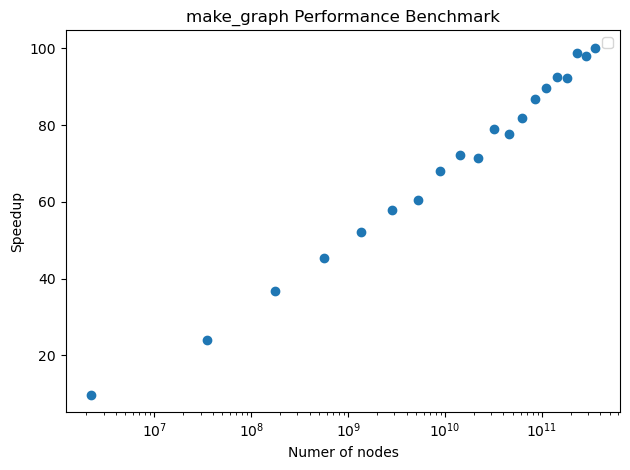

In [34]:
import matplotlib.pyplot as plt
plt.scatter(x=times["NumberofNodes"], y=np.array(times["Original"]/times["Fast"]))
plt.ylabel("Speedup")
plt.xlabel("Fraction of data")
plt.ylabel("Speedup")
plt.title("make_graph Performance Benchmark")
plt.legend()
plt.xscale("log")
plt.xlabel("Numer of nodes")
plt.tight_layout()
plt.show()

# New get_groups

In [60]:
def get_groups(self., l=0):
    """
    return groups

    :param l: hierarchy level
    """

    state_l = self.state.project_level(l).copy(overlap=True)
    state_l_edges = state_l.get_edge_blocks()
    B = state_l.get_B()
    D, W, K = self.get_shape()

    n_wb = np.zeros((W, B))  ## number of half-edges incident on word-node w and labeled as word-group tw
    n_w_key_b = [np.zeros((K[ik], B)) for ik in range(self.nbranches)]  ## number of half-edges incident on word-node w and labeled as word-group tw
    n_db = np.zeros((D, B))  ## number of half-edges incident on document-node d and labeled as document-group td
    n_dbw = np.zeros((D, B)) ## number of half-edges incident on document-node d and labeled as word-group tw
    n_dbw_key = [np.zeros((D, B)) for _ in range(self.nbranches)] ## number of half-edges incident on document-node d and labeled as keyword-group tw_key

    for e in self.g.edges():
        z1, z2 = state_l_edges[e]
        v1 = e.source()
        v2 = e.target()
        weight = self.g.ep["count"][e]
        n_db[int(v1), z1] += weight
        kind = self.g.vp['kind'][v2]
        if kind == 1:
            n_wb[int(v2) - D, z2] += weight
            n_dbw[int(v1), z2] += weight
        else:
            n_w_key_b[kind-2][int(v2) - D - W - sum(K[:(kind-2)]), z2] += weight
            n_dbw_key[kind-2][int(v1), z2] += weight

    #p_w = np.sum(n_wb, axis=1) / float(np.sum(n_wb))

    ind_d = np.where(np.sum(n_db, axis=0) > 0)[0]
    Bd = len(ind_d)
    n_db = n_db[:, ind_d]

    ind_w = np.where(np.sum(n_wb, axis=0) > 0)[0]
    Bw = len(ind_w)
    n_wb = n_wb[:, ind_w]

    ind_w2 = np.where(np.sum(n_dbw, axis=0) > 0)[0]
    n_dbw = n_dbw[:, ind_w2]

    ind_w_key = []
    ind_w2_keyword = []
    Bk = []

    for ik in range(self.nbranches):
        ind_w_key.append(np.where(np.sum(n_w_key_b[ik], axis=0) > 0)[0])
        Bk.append(len(ind_w_key[ik]))
        n_w_key_b[ik] = n_w_key_b[ik][:, ind_w_key[ik]]
        
        ind_w2_keyword.append(np.where(np.sum(n_dbw_key[ik], axis=0) > 0)[0])
        n_dbw_key[ik] = n_dbw_key[ik][:, ind_w2_keyword[ik]]
    

    # group membership of each word-node P(t_w | w)
    p_tw_w = (n_wb / np.sum(n_wb, axis=1)[:, np.newaxis]).T

    p_tk_w_key = []
    for ik in range(self.nbranches):
        # group membership of each keyword-node P(t_k | keyword)
        p_tk_w_key.append((n_w_key_b[ik] / np.sum(n_w_key_b[ik], axis=1)[:, np.newaxis]).T)
    
    ## topic-distribution for words P(w | t_w)
    p_w_tw = n_wb / np.sum(n_wb, axis=0)[np.newaxis, :]
    
    p_w_key_tk = []
    for ik in range(self.nbranches):
        ## topickey-distribution for keywords P(keyword | t_w_key)
        p_w_key_tk.append(n_w_key_b[ik] / np.sum(n_w_key_b[ik], axis=0)[np.newaxis, :])
    
    ## Mixture of word-groups into documetns P(t_w | d)
    p_tw_d = (n_dbw / np.sum(n_dbw, axis=1)[:, np.newaxis]).T

    p_tk_d = []
    for ik in range(self.nbranches):
        ## Mixture of word-groups into documetns P(t_w | d)
        p_tk_d.append((n_dbw_key[ik] / np.sum(n_dbw_key[ik], axis=1)[:, np.newaxis]).T)
    
    # group membership of each doc-node P(t_d | d)
    p_td_d = (n_db / np.sum(n_db, axis=1)[:, np.newaxis]).T

    result = {}
    result['Bd'] = Bd
    result['Bw'] = Bw
    result['Bk'] = Bk
    result['p_tw_w'] = p_tw_w
    result["p_tk_w_key"] = p_tk_w_key
    result['p_td_d'] = p_td_d
    result['p_w_tw'] = p_w_tw
    result['p_w_key_tk'] = p_w_key_tk
    result['p_tw_d'] = p_tw_d
    result['p_tk_d'] = p_tk_d

    self.groups[l] = result

    return result

def _get_edge_cache(self):
    """
    Cache edge sources, targets, weights, and kinds once per graph.
    """
    if hasattr(self, "_edge_cache"):
        return self._edge_cache

    edge_array = self.g.get_edges()  # shape (m, 2)
    sources = edge_array[:, 0].astype(np.int64)
    targets = edge_array[:, 1].astype(np.int64)

    weights = self.g.ep["count"].a.astype(np.float64)
    kinds = self.g.vp["kind"].a[targets].astype(np.int64)

    self._edge_cache = {
        "sources": sources,
        "targets": targets,
        "weights": weights,
        "kinds": kinds,
    }
    return self._edge_cache


def _get_state_l_edges_array(self, state_l):
    """
    Cache block assignments (z1, z2) once per hierarchy level.
    """
    if hasattr(state_l, "_edges_array_cache"):
        return state_l._edges_array_cache

    edges = list(self.g.edges())
    state_l_edges = state_l.get_edge_blocks()

    arr = np.empty((len(edges), 2), dtype=np.int64)
    for i, e in enumerate(edges):
        arr[i, 0] = state_l_edges[e][0]
        arr[i, 1] = state_l_edges[e][1]

    state_l._edges_array_cache = arr
    return arr


def get_groups_fast(self, l=0):
    """
    Fully optimized get_groups with caching of edges and block assignments.
    No per-edge Python loops in the hot path.
    """
    if l in self.groups:
        return self.groups[l]

    # --- Setup ---
    state_l = self.state.project_level(l).copy(overlap=True)
    B = state_l.get_B()
    D, W, K = self.get_shape()
    nbranches = self.nbranches
    K_arr = np.array(K, dtype=np.int64)

    # --- Precompute branch offsets ---
    if nbranches > 0 and K_arr.size > 0:
        prefix_K = np.empty(nbranches, dtype=np.int64)
        prefix_K[0] = 0
        for ii in range(1, nbranches):
            prefix_K[ii] = prefix_K[ii-1] + K_arr[ii-1]
        offsets = (D + W) + prefix_K
    else:
        offsets = np.empty(0, dtype=np.int64)

    # --- Get cached edge arrays ---
    edge_cache = _get_edge_cache(self)
    sources = edge_cache["sources"]
    targets = edge_cache["targets"]
    weights = edge_cache["weights"]
    kinds = edge_cache["kinds"]

    # --- Get cached block assignments ---
    z_pairs = _get_state_l_edges_array(self, state_l)
    z1_arr = z_pairs[:, 0]
    z2_arr = z_pairs[:, 1]

    # --- Allocate accumulators ---
    n_wb = np.zeros((W, B), dtype=np.float64)
    n_db = np.zeros((D, B), dtype=np.float64)
    n_dbw = np.zeros((D, B), dtype=np.float64)
    n_w_key_b3 = np.zeros((nbranches, np.max(K_arr) if nbranches > 0 else 0, B), dtype=np.float64)
    n_dbw_key3 = np.zeros((nbranches, D, B), dtype=np.float64)

    # --- Process edges ---
    process_edges_numba_stack(
        sources, targets, z1_arr, z2_arr, kinds, weights,
        D, W, K_arr, offsets, nbranches,
        n_db, n_wb, n_dbw, n_w_key_b3, n_dbw_key3
    )

    # --- Trim and normalize (unchanged) ---
    ind_d = np.where(np.sum(n_db, axis=0) > 0)[0]
    n_db = n_db[:, ind_d]
    Bd = len(ind_d)

    ind_w = np.where(np.sum(n_wb, axis=0) > 0)[0]
    n_wb = n_wb[:, ind_w]
    Bw = len(ind_w)

    ind_w2 = np.where(np.sum(n_dbw, axis=0) > 0)[0]
    n_dbw = n_dbw[:, ind_w2]

    n_w_key_b_list, n_dbw_key_list, Bk = [], [], []
    for ik in range(nbranches):
        Kk = int(K_arr[ik]) if K_arr.size > 0 else 0
        if Kk > 0:
            col_sums = np.sum(n_w_key_b3[ik, :Kk, :], axis=0)
            ind_wk = np.where(col_sums > 0)[0]
            if ind_wk.size > 0:
                n_w_key_b_list.append(n_w_key_b3[ik, :Kk, :][:, ind_wk].copy())
            else:
                n_w_key_b_list.append(np.zeros((Kk, 0), dtype=np.float64))
            Bk.append(len(ind_wk))
        else:
            n_w_key_b_list.append(np.zeros((0, 0), dtype=np.float64))
            Bk.append(0)

        col_sums_dbw = np.sum(n_dbw_key3[ik], axis=0)
        ind_w2k = np.where(col_sums_dbw > 0)[0]
        if ind_w2k.size > 0:
            n_dbw_key_list.append(n_dbw_key3[ik][:, ind_w2k].copy())
        else:
            n_dbw_key_list.append(np.zeros((D, 0), dtype=np.float64))

    # --- Distributions ---
    denom = np.sum(n_wb, axis=1, keepdims=True)
    p_tw_w = (n_wb / denom).T

    p_tk_w_key = []
    for ik in range(nbranches):
        arr = n_w_key_b_list[ik]
        denom = np.sum(arr, axis=1, keepdims=True)
        p_tk_w_key.append((arr / denom).T)

    denom = np.sum(n_wb, axis=0, keepdims=True)
    p_w_tw = n_wb / denom

    p_w_key_tk = []
    for ik in range(nbranches):
        arr = n_w_key_b_list[ik]
        denom = np.sum(arr, axis=0, keepdims=True)
        p_w_key_tk.append(arr / denom)

    denom = np.sum(n_dbw, axis=1, keepdims=True)
    p_tw_d = (n_dbw / denom).T

    p_tk_d = []
    for ik in range(nbranches):
        arr = n_dbw_key_list[ik]
        denom = np.sum(arr, axis=1, keepdims=True)
        p_tk_d.append((arr / denom).T)

    denom = np.sum(n_db, axis=1, keepdims=True)
    p_td_d = (n_db / denom).T

    result = {
        'Bd': Bd, 'Bw': Bw, 'Bk': Bk,
        'p_tw_w': p_tw_w, 'p_tk_w_key': p_tk_w_key, 'p_td_d': p_td_d,
        'p_w_tw': p_w_tw, 'p_w_key_tk': p_w_key_tk, 'p_tw_d': p_tw_d, 'p_tk_d': p_tk_d
    }

    self.groups[l] = result
    return result


In [62]:
# Assume compare_groups_results is already defined (handles scalars, arrays, lists, NaNs)
# from previous code
def compare_groups_results(r1, r2, atol=1e-12, name="root"):
    """
    Compare two get_groups-like results.

    Raises AssertionError if any mismatch.
    Prints detailed info about differences.
    """
    for key in r1:
        val1 = r1[key]
        val2 = r2[key]
        full_name = f"{name}.{key}"

        # Check type mismatch
        assert type(val1) == type(val2), f"Type mismatch for {full_name}: {type(val1)} vs {type(val2)}"

        if isinstance(val1, list):
            assert len(val1) == len(val2), f"List length mismatch for {full_name}"
            for i, (a, b) in enumerate(zip(val1, val2)):
                elem_name = f"{full_name}[{i}]"
                if isinstance(a, np.ndarray):
                    assert a.shape == b.shape, f"Shape mismatch for {elem_name}: {a.shape} vs {b.shape}"
                    mask = ~np.isclose(a, b, atol=atol, equal_nan=True)
                    if np.any(mask):
                        idx = np.argwhere(mask)
                        n_diff = len(idx)
                        print(f"{elem_name}: {n_diff} differences found")
                        for j, (r, c) in enumerate(idx[:20]):
                            print(f"{elem_name}[{r},{c}]: {a[r,c]} vs {b[r,c]}")
                        if n_diff > 20:
                            print(f"... and {n_diff - 20} more differences")
                        raise AssertionError(f"{elem_name} arrays differ")
                else:  # scalar in list
                    assert a == b, f"Scalar mismatch in {elem_name}: {a} vs {b}"

        elif isinstance(val1, np.ndarray):
            assert val1.shape == val2.shape, f"Shape mismatch for {full_name}: {val1.shape} vs {val2.shape}"
            mask = ~np.isclose(val1, val2, atol=atol, equal_nan=True)
            if np.any(mask):
                idx = np.argwhere(mask)
                n_diff = len(idx)
                print(f"{full_name}: {n_diff} differences found")
                for j, (r, c) in enumerate(idx[:20]):
                    print(f"{full_name}[{r},{c}]: {val1[r,c]} vs {val2[r,c]}")
                if n_diff > 20:
                    print(f"... and {n_diff - 20} more differences")
                raise AssertionError(f"{full_name} arrays differ")

        else:  # scalar
            assert val1 == val2, f"Scalar mismatch for {full_name}: {val1} vs {val2}"

    print("All keys match exactly (within tolerance and NaN equality).")
    
def benchmark_get_groups(self., l=0):
    """
    Benchmark original, optimized, and Numba-safe get_groups functions.
    """

    print("Starting benchmarking...\n")
    
    # --- 1. Original ---
    self.groups={}
    start = time.time()
    res_orig = get_groups(self., l=l)
    t_orig = time.time() - start

    # --- 2. fast ---
    self.groups={}
    start = time.time()
    res_fast = get_groups_fast(self., l=l)
    t_fast = time.time() - start

    # --- Verify results ---
    print("Verifying fast vs original...")
    compare_groups_results(res_orig, res_fast)
    print("Optimized version matches original!\n")

    # --- Summary ---
    print("Benchmark summary (seconds):")
    print(f"Original: {t_orig:.4f}")
    print(f"Optimized: {t_fast:.4f} (speedup {t_orig/t_fast:.2f}x)")

    return t_orig, t_fast

In [63]:
mdata=read_h5mu("../Test_data.h5mu")
mdata

MuData object with n_obs × n_vars = 1000 × 2200
  var:	'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
  3 modalities
    Peak:	1000 x 1000
      obs:	'RNA_celltype', 'Raw_CellType', 'CellType', 'nucleosome_signal', 'tss_enrichment_score', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'tss', 'passes_filter'
      var:	'chr', 'start', 'stop', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    mRNA:	1000 x 700
      var:	'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    lncRNA:	1000 x 500
      var:	'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'

In [64]:
data={}
data["Original"]=[]
data["Fast"]=[]
data["NumberofNodes"]=[]

for n in np.array(np.linspace(0.5,10, 20)/10):
    mdata_sub = subsample_mudata(mdata, cell_frac=n, strat_mod="Peak", strat_col="CellType", random_seed=123)
    print(n, mdata_sub.shape)

    self.=bionsbm(mdata_sub)
    modalities=list(mdata_sub.mod.keys())   
    dfs=[mdata_sub[key].to_df().T for key in modalities]
    self.make_graph(dfs[0], dfs[1:])
    self.fit(verbose=False, n_init=1, parallel=False)
    
    old_t, new_t = benchmark_get_groups(self., l=0)
    data["Original"].append(old_t)
    data["Fast"].append(new_t)
    data["NumberofNodes"].append(np.prod((mdata_sub.shape[0], mdata_sub["Peak"].shape[1], mdata_sub["mRNA"].shape[1], mdata_sub["lncRNA"].shape[1])))

2025-09-15 15:35:00,291 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:35:00,338 - INFO - Fit number: 0


0.05 (51, 110)
Starting benchmarking...



2025-09-15 15:35:19,449 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:35:19,495 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3024
Optimized: 0.2523 (speedup 9.13x)
0.1 (99, 220)
Starting benchmarking...



2025-09-15 15:35:34,004 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:35:34,052 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3306
Optimized: 0.2698 (speedup 8.64x)
0.15 (150, 330)
Starting benchmarking...



2025-09-15 15:35:54,452 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:35:54,500 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3394
Optimized: 0.1262 (speedup 18.54x)
0.2 (201, 440)
Starting benchmarking...



2025-09-15 15:36:04,307 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:36:04,355 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3065
Optimized: 0.1273 (speedup 18.12x)
0.25 (250, 550)
Starting benchmarking...



2025-09-15 15:36:14,513 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:36:14,561 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3455
Optimized: 0.1276 (speedup 18.39x)
0.3 (301, 660)
Starting benchmarking...



2025-09-15 15:36:25,937 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:36:25,987 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.4355
Optimized: 0.1320 (speedup 18.46x)
0.35 (351, 770)
Starting benchmarking...



2025-09-15 15:36:41,990 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:36:42,038 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3384
Optimized: 0.1284 (speedup 18.22x)
0.4 (400, 880)
Starting benchmarking...



2025-09-15 15:36:52,243 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:36:52,291 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3443
Optimized: 0.1304 (speedup 17.98x)
0.45 (450, 990)
Starting benchmarking...



2025-09-15 15:37:09,187 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:37:09,237 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.4236
Optimized: 0.1302 (speedup 18.61x)
0.5 (498, 1100)
Starting benchmarking...



2025-09-15 15:37:32,855 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:37:32,903 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.4419
Optimized: 0.1287 (speedup 18.97x)
0.55 (550, 1211)
Starting benchmarking...



2025-09-15 15:37:44,111 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:37:44,159 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3267
Optimized: 0.1279 (speedup 18.20x)
0.6 (600, 1320)
Starting benchmarking...



2025-09-15 15:37:57,758 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:37:57,806 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3155
Optimized: 0.1264 (speedup 18.32x)
0.65 (649, 1430)
Starting benchmarking...



2025-09-15 15:38:08,683 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:38:08,730 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3099
Optimized: 0.1282 (speedup 18.02x)
0.7 (699, 1540)
Starting benchmarking...



2025-09-15 15:38:19,359 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:38:19,405 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3180
Optimized: 0.1284 (speedup 18.05x)
0.75 (750, 1650)
Starting benchmarking...



2025-09-15 15:38:29,572 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:38:29,624 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.3703
Optimized: 0.1300 (speedup 18.23x)
0.8 (799, 1760)
Starting benchmarking...



2025-09-15 15:38:42,950 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:38:43,000 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.4467
Optimized: 0.1323 (speedup 18.49x)
0.85 (850, 1870)
Starting benchmarking...



2025-09-15 15:38:59,259 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:38:59,309 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 2.4565
Optimized: 0.1315 (speedup 18.67x)
0.9 (901, 1980)
Starting benchmarking...



2025-09-15 15:39:50,787 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:39:50,883 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 5.3818
Optimized: 0.2484 (speedup 21.67x)
0.95 (949, 2090)
Starting benchmarking...



2025-09-15 15:40:20,245 - INFO - Loading graph from results/mymodel_graph.xml.gz
2025-09-15 15:40:20,335 - INFO - Fit number: 0


Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 4.4649
Optimized: 0.2231 (speedup 20.01x)
1.0 (1000, 2200)
Starting benchmarking...

Verifying fast vs original...
All keys match exactly (within tolerance and NaN equality).
Optimized version matches original!

Benchmark summary (seconds):
Original: 4.4091
Optimized: 0.2279 (speedup 19.35x)


In [65]:
import json
with open('time_get_groups.json', 'w') as f:
    json.dump(pd.DataFrame.from_dict(data).astype(float).to_dict('list'), f)

In [66]:
times=pd.DataFrame.from_dict(data)
times

,Original,Fast,NumberofNodes
0,2.302358,0.252295,2231250
1,2.330616,0.269839,34650000
2,2.339375,0.126173,177187500
3,2.306452,0.127278,562800000
4,2.345476,0.127560,1367187500
5,2.435526,0.131968,2844450000
6,2.338365,0.128355,5267193750
7,2.344316,0.130358,8960000000
8,2.423572,0.130237,14352187500
9,2.441889,0.128721,21787500000


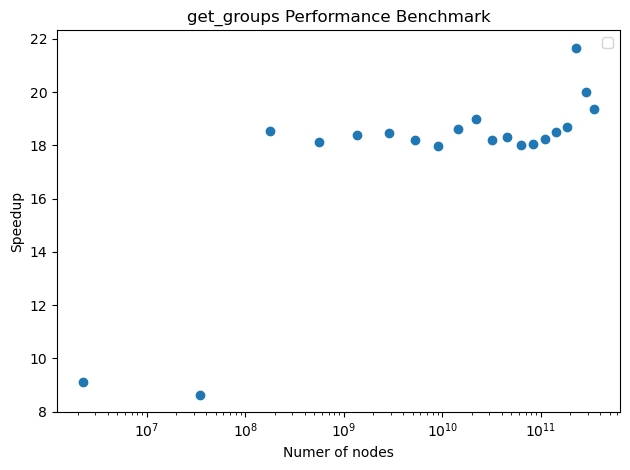

In [67]:
import matplotlib.pyplot as plt
plt.scatter(x=times["NumberofNodes"], y=np.array(times["Original"]/times["Fast"]))
plt.ylabel("Speedup")
plt.xlabel("Fraction of data")
plt.ylabel("Speedup")
plt.title("get_groups Performance Benchmark")
plt.legend()
plt.xscale("log")
plt.xlabel("Numer of nodes")
plt.tight_layout()
plt.show()